# MCS

_see markdown file for half-baked theory_

Constants:
- $V_n$: coefficient of variation of the expected value of the winning ticket
- $N_{s,min}$: minimum number of samples to estimate the expected value of the number of winning tickets

Procedure is:

1. Determine the set of tickets (size $N_t$) to purchase, $T$, defined by minutes $m$
2. Compute total cost $3\cdot N_t$

For each ticket $i$ in $T$ associated with minute $m_i$:
1. Compute probability of being the winning ticket, $p_i=P[M=m_i=m_w]$
2. Sample $N_w(m_i)$; stop when expected value of samples satisfies the criteria defined above (sample index $j=1,\ldots,N_{s,i}$)
3. Compute the profit from each realization $j$ for minute $i$ as $W \cdot p_i / N_{w, j}$

The samples of $B$ are the collection of all profits computed for the samples of $i$

In [24]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from tickets import *
from minutes import *
from models import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
pickle_path = os.path.join('pickles',
                           'List_of_kde_scaled.pkl')

with open(pickle_path, 'rb') as f:
    loaded_radial_dist_list = pickle.load(f)

In [26]:
def sample_benefit_test(probabilities, cov, N_min, N_max, verbose=True):
    sample = sample_ticket(probabilities, cov, N_min, N_max, verbose)
    return 300/(sample + 1)



prob = loaded_radial_dist_list[0]#[32484]
sample = sample_benefit_test(prob, 0.1, 100, 10000)


Sample size: 100, CoV: 0.024


Value: 100.0, Frequency: 7
Value: 150.0, Frequency: 93


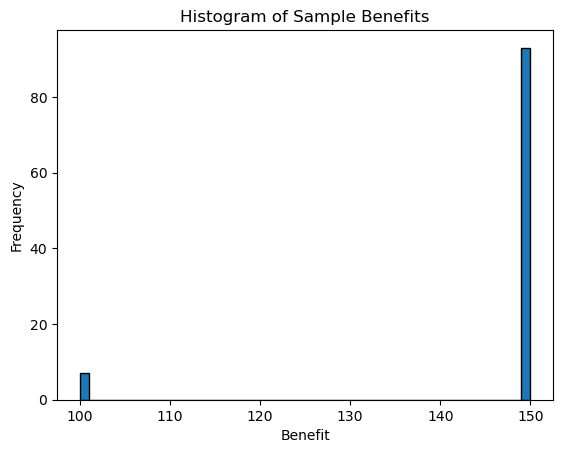

In [27]:
unique, counts = np.unique(sample, return_counts=True)
for value, count in zip(unique, counts):
    print(f"Value: {value}, Frequency: {count}")

plt.hist(sample, bins=50, edgecolor='k')
plt.xlabel('Benefit')
plt.ylabel('Frequency')
plt.title('Histogram of Sample Benefits')
plt.show()


In [28]:


def plot_hist_and_cdf(sampled_profit, xlim=None, ylim=None):
    fig, ax1 = plt.subplots()

    # Plot histogram
    ax1.hist(sampled_profit, bins=50, edgecolor='k', density=True, alpha=0.6, label='Histogram')
    ax1.set_xlabel('thousands of dollars')
    ax1.set_ylabel('Frequency')
    ax1.legend(loc='upper left')

    # Create a second y-axis for the cumulative distribution
    ax2 = ax1.twinx()
    sorted_samples = np.sort(sampled_profit)
    cdf = np.arange(1, len(sorted_samples) + 1) / (len(sorted_samples) + 1)
    ax2.plot(sorted_samples, cdf, color='red', label='CDF')
    ax2.set_ylabel('Cumulative Probability')
    ax2.legend(loc='upper right')

    # plt.title('Histogram and Cumulative Distribution of Sample Benefits')
    plt.show()

    # Plot exceedance probability
    fig, ax = plt.subplots()
    exceedance_prob = 1 - cdf
    ax.plot(sorted_samples, exceedance_prob, color='blue', label='Exceedance Probability')
    ax.vlines(300, 0, 1, color='grey', linestyle='--', label='300k threshold')
    ax.set_xlabel('thousands of dollars')
    ax.set_ylabel('Exceedance Probability')
    ax.set_xscale('log')
    ax.set_yscale('log')
    if xlim is not None:
        ax.set_xlim(*xlim)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.legend(loc='upper right')
    plt.show()


Name: no name
Reference: April 1
Days: 60
Number of tickets: 4320
Cost for all tickets: 12960.0



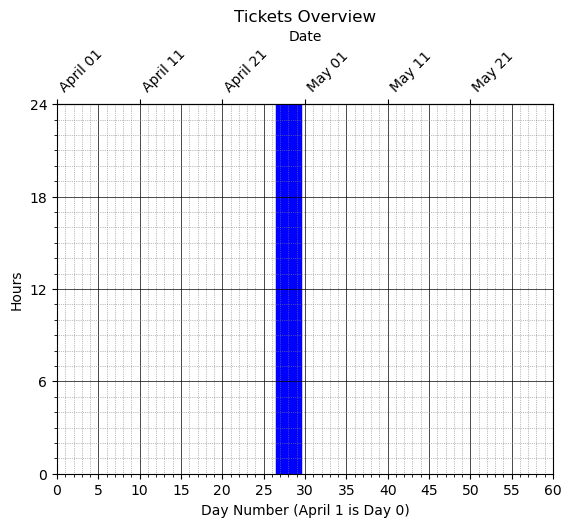

In [29]:
t = Tickets()
t.add([[27, 28, 29]])
# t.add([[14], [13]])
t.status()
t.show()

Number of tickets: 	4320
Cost tickets: 		 1.30e+01 kUSD 	(12960 USD)
Expected winnings: 	 2.99e+00 kUSD 	( 2994 USD)
Expected profit: 	-9.97e+00 kUSD 	(-9966 USD)


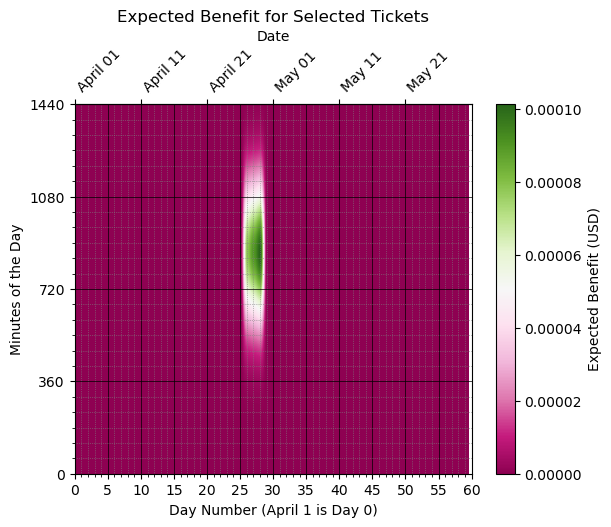

In [37]:
m = Models(model_id=2)
prob_T = np.zeros((len(t.tickets)))
Nw_T = np.zeros((len(t.tickets)))
for i, ti in enumerate(t.tickets):
    prob_T[i] = m.get_p([ti])
    day, min = Minutes.get_day_min(ti)
    Nw_T [i] = m.ticket_model(day, min)
prob_T_matrix = m.map_data_to_day_min(prob_T, t.tickets)
prob_all = np.sum(prob_T)
print(f"The probability of a ticket winning is {prob_all:.3e}")
cost_tickets = len(t.tickets)*3
expected_winnings = np.sum(300*prob_T/(Nw_T + 1))
expected_profit = expected_winnings - .003*len(t.tickets)
print(f"Number of tickets: \t{len(t.tickets)}")
print(f"Cost tickets: \t\t{cost_tickets/1000:9.2e} kUSD \t({len(t.tickets)*3:5.0f} USD)")
print(f"Expected winnings: \t{expected_winnings:9.2e} kUSD \t({expected_winnings*1000:5.0f} USD)")
print(f"Expected profit: \t{expected_profit:9.2e} kUSD \t({expected_profit*1000:5.0f} USD)")

m.plot(prob_T_matrix)

In [31]:
Ns = 100000
sampled_ticket = np.zeros((Ns,), dtype=int)
sampled_probability = np.zeros((Ns,))
sampled_winnings = np.zeros((Ns,))
for i in range(Ns):
    sampled_ticket[i] = random.choices(t.tickets, weights=prob_T, k=1)[0]
    sampled_probability[i] = prob_T[
        t.tickets.index(sampled_ticket[i])]
    sampled_winnings[i] = 300/(1 +sample_integer(
        loaded_radial_dist_list[sampled_ticket[i]]))




Running the simulation for N simulations takes:

| $N_t$ | N | Time |
| :---: | :---: | :---: |
| | 1e7 | stopped after 5 min |
| 180 | 1e5 | 10 s |
| 4320 | 1e5 | 1 min 8 sec |


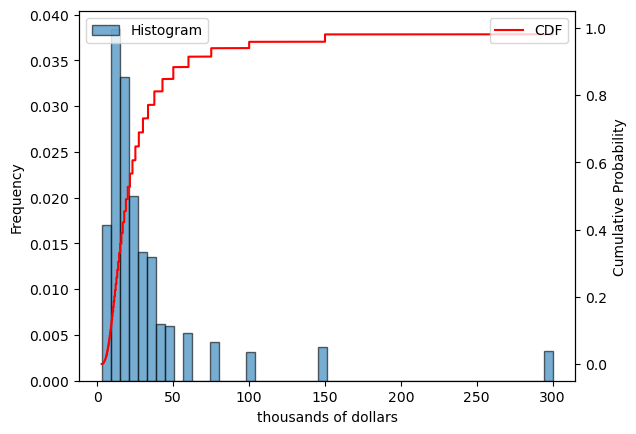

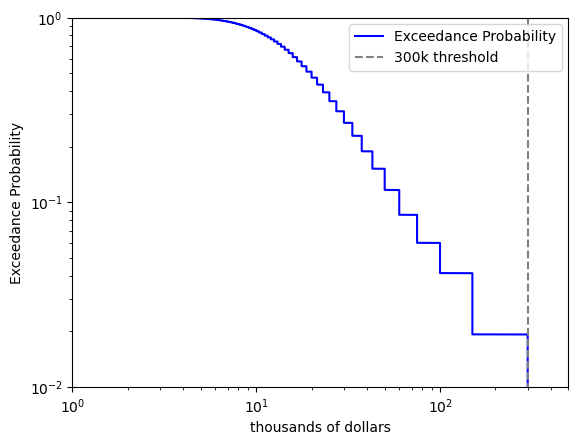

In [32]:
plot_hist_and_cdf(sampled_winnings,
                  xlim=(1,500), ylim=(1e-2, 1))

    USING EXPECTED VALUE CALC    
Number of tickets: 	4320
Cost tickets: 		 1.30e+01 kUSD 	(12960 USD)
Expected winnings: 	 2.99e+00 kUSD 	( 2994 USD)
Expected profit: 	-9.97e+00 kUSD 	(-9966 USD)
    USING MONTE CARLO SIMULATION    
Tickets purchased: 4320
Expected winnings:  1.42e-03 kUSD (    1 USD)
Expected profit:   -1.30e+01 kUSD (-12959 USD)
Min loss =    -287.040
Max loss =      10.156
Mean loss =    -19.979
Median loss =   -7.040
Std loss =      45.613


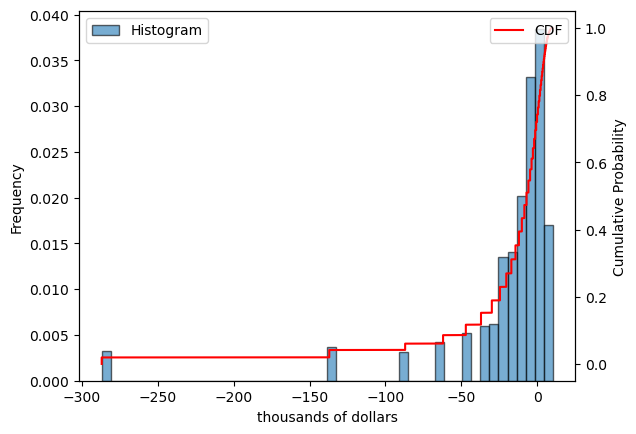

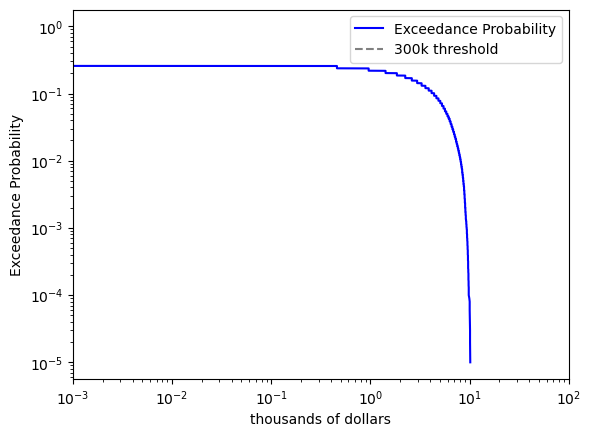

In [40]:
print("=====================================")
print("    USING EXPECTED VALUE CALC    ")
print("=====================================")
print(f"Number of tickets: \t{len(t.tickets)}")
print(f"Cost tickets: \t\t{cost_tickets/1000:9.2e} kUSD \t({len(t.tickets)*3:5.0f} USD)")
print(f"Expected winnings: \t{expected_winnings:9.2e} kUSD \t({expected_winnings*1000:5.0f} USD)")
print(f"Expected profit: \t{expected_profit:9.2e} kUSD \t({expected_profit*1000:5.0f} USD)")
print("=====================================")
print("    USING MONTE CARLO SIMULATION    ")
print("=====================================")
print(f"Tickets purchased: {t.N()}")
# FD_expected_winnings_conditional = np.sum(prob_all*sampled_winnings)
FD_expected_winnings = np.sum(sampled_probability*sampled_winnings/(Ns+1))
# print(f"Expected winnings conditional: {FD_expected_winnings_conditional:.2e}")
print(f"Expected winnings: {FD_expected_winnings:9.2e} kUSD ({FD_expected_winnings*1000:5.0f} USD)")
FD_expected_profit = FD_expected_winnings - t.N()/1000*3
print(f"Expected profit:   {FD_expected_profit:9.2e} kUSD ({FD_expected_profit*1000:5.0f} USD)")
sampled_loss = 3*t.N()/1000 - sampled_winnings
print(f"Min loss =    {np.min(sampled_loss):8.3f}")
print(f"Max loss =    {np.max(sampled_loss):8.3f}")
print(f"Mean loss =   {np.mean(sampled_loss):8.3f}")
print(f"Median loss = {np.median(sampled_loss):8.3f}")
print(f"Std loss =    {np.std(sampled_loss):8.3f}")

plot_hist_and_cdf(sampled_loss, xlim=(.001,100))
# prob_T_matrix = m.map_data_to_day_min(prob_T, t.tickets)
# m.plot(prob_T_matrix)

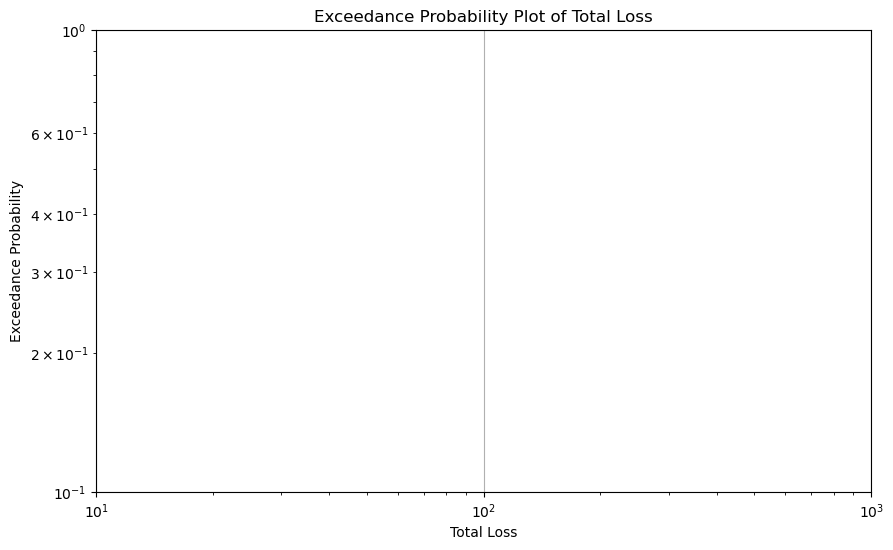

In [34]:
# Sort the total_profit array in descending order
sorted_loss = np.sort(sampled_loss)[::-1]

# Calculate the exceedance probability
exceedance_prob = np.arange(1, len(sorted_loss) + 1) / (len(sorted_loss) + 1)

# Plot the exceedance probability
plt.figure(figsize=(10, 6))
plt.plot(sorted_loss, exceedance_prob, marker='o', linestyle='-', color='b')
plt.xlabel('Total Loss')
plt.ylabel('Exceedance Probability')
plt.title('Exceedance Probability Plot of Total Loss')
plt.xscale('log')
plt.yscale('log')
plt.xlim([10, 1000])
plt.ylim([0.1, 1])
plt.grid(True)
plt.show()

In [35]:
type(int(round(np.random.choice(t.tickets))))

int

In [36]:
test = np.zeros((3,))
print(test)
print(test.shape)
test = np.append(test, [1,2,3])
test.shape
print(test)

[0. 0. 0.]
(3,)
[0. 0. 0. 1. 2. 3.]
